In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Summary
I scraped data for the dnd Classics off dmsguild.com and built a csv. For price, I tried to pull the non-sale price, but as the Black Friday sale was going on while I did the scraping, some of the prices might not be accurate.

You can't easily scrape the setting, so I updated all of that by hand. You can see a block of code at the bottom where I did a number programmatically, but most of them I hand coded either from memory or looking up their details on dm's guild. There are probably some that are wrong where I changed my assumptions later - ie I might have tagged a few products as Forgotten Realms that I would have later tagged as Kara-Tur. But it should be at least 90% correct and consistent.

When in doubt, I tagged "no setting".

# Data Pipeline


In [8]:
import pandas as pd

def load_data(file_path):
  df = pd.read_csv(file_path)
  return df

# Find invalid dates by attempting conversion
def find_invalid_dates(df, column_name):
    # Coerce invalid dates to NaT (Not a Time)
    dates = pd.to_datetime(df[column_name], errors='coerce')
    # Find rows where conversion failed
    invalid_dates = df[dates.isna()]
    return invalid_dates

def clean_data(df):
  # Strip the time portion where provided and convert to datetime with error handling
  df['date_added'] = pd.to_datetime(products_df['date_added'].str.split(' ').str[0],
                                         errors='coerce',
                                         format='mixed')
  df['min_sales'] = df['metal'].apply(get_min_sales)

  return df

def data_quality(df):
  # check for null values
  for column in df.columns:
    null_count = df[column].isnull().sum()
    print(f"Null count for {column}: {null_count}")

  # chack date columns
  bad_dates = find_invalid_dates(df, 'date_added')
  print(f'bad dates: {bad_dates}')

def get_min_sales(metal):
    metal_to_min_sales = {
        'Adamantine seller': 5000,
        'Mithral seller': 2500,
        'Platinum seller': 1000,
        'Gold seller': 500,
        'Electrum seller': 250,
        'Silver seller': 100,
        'Copper seller': 50,
        'None': 0
    }
    return metal_to_min_sales.get(metal, 0)  # Returns 0 if metal not found

products_df = load_data(file_path='/content/drive/MyDrive/dmsguild_products_settings.csv')
products_df = clean_data(products_df)
data_quality(products_df)

Null count for name: 0
Null count for metal: 0
Null count for date_added: 0
Null count for url: 0
Null count for rating: 121
Null count for edition: 4
Null count for authors: 0
Null count for artists: 0
Null count for pages: 81
Null count for price: 156
Null count for ratings_count: 121
Null count for setting: 0
Null count for min_sales: 0
bad dates: Empty DataFrame
Columns: [name, metal, date_added, url, rating, edition, authors, artists, pages, price, ratings_count, setting, min_sales]
Index: []


# Start with some quick visualizations

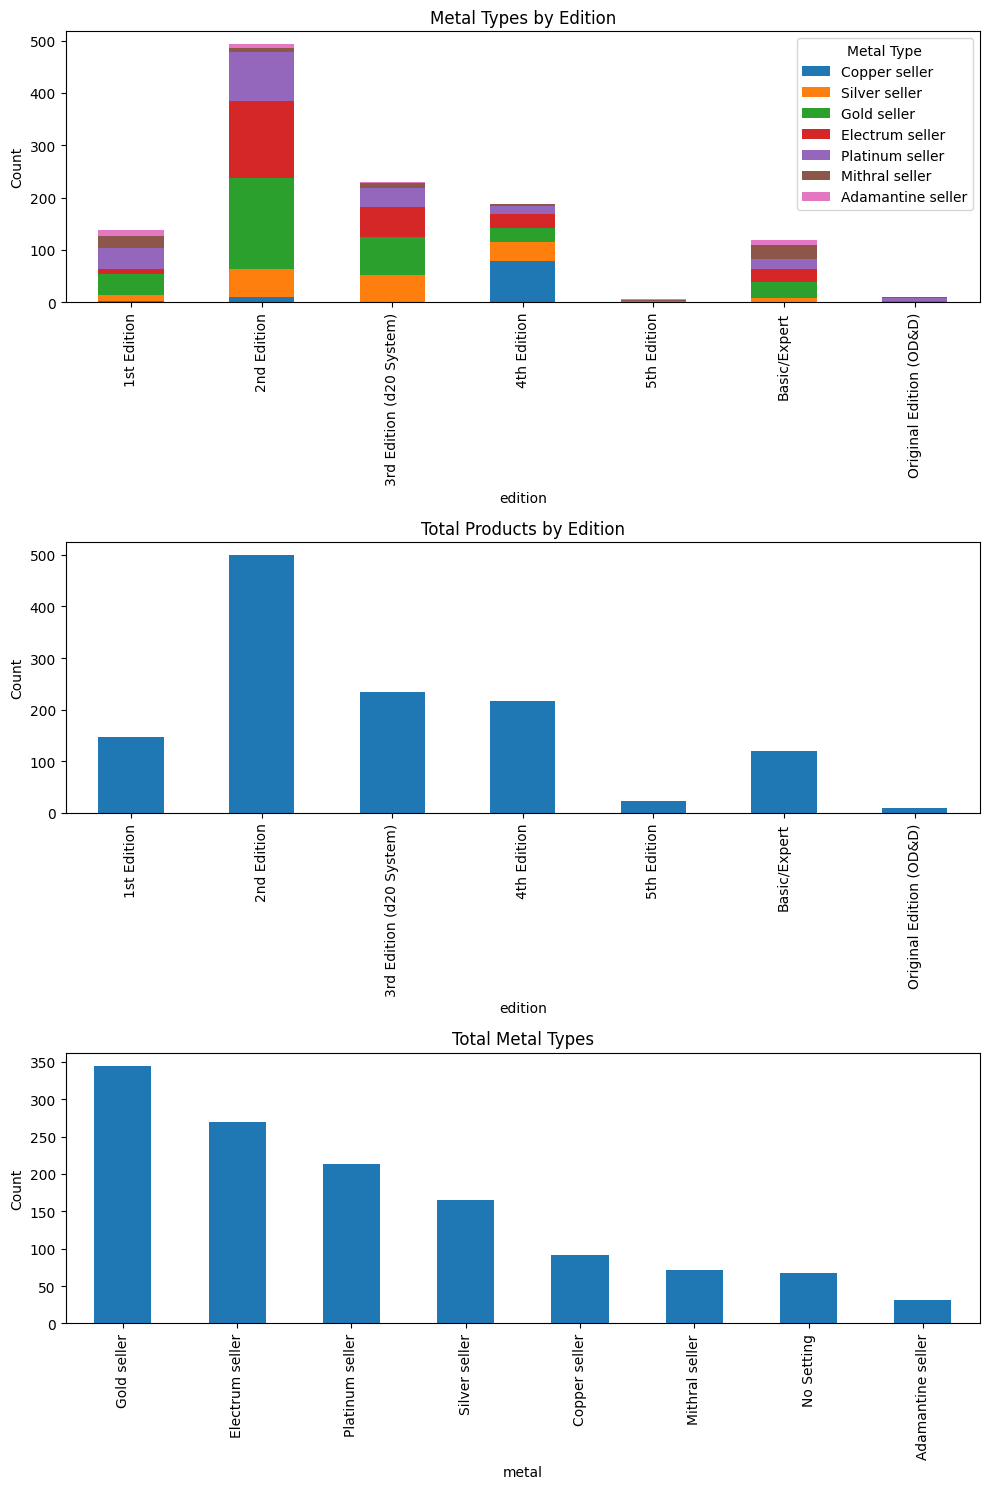

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Get counts
metal_counts = products_df.groupby('edition')['metal'].value_counts().unstack(fill_value=0)
product_counts = products_df.groupby('edition')['name'].count()
total_metals = products_df['metal'].value_counts()
#desired_order = ['Adamantine seller', 'Mithral seller', 'Platinum seller', 'Electrum seller', 'Gold seller', 'Silver seller', 'Copper seller']  # adjust as needed
desired_order = ['Copper seller', 'Silver seller', 'Gold seller', 'Electrum seller', 'Platinum seller', 'Mithral seller', 'Adamantine seller']
metal_counts = metal_counts[desired_order]

# Create 3 subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 15))

# Metal by edition
metal_counts.plot(kind='bar', stacked=True, ax=ax1)
ax1.set_title('Metal Types by Edition')
ax1.set_ylabel('Count')
ax1.legend(title='Metal Type')

# Products by edition
product_counts.plot(kind='bar', ax=ax2)
ax2.set_title('Total Products by Edition')
ax2.set_ylabel('Count')

# Total metals
total_metals.plot(kind='bar', ax=ax3)
ax3.set_title('Total Metal Types')
ax3.set_ylabel('Count')

plt.tight_layout()
plt.show()

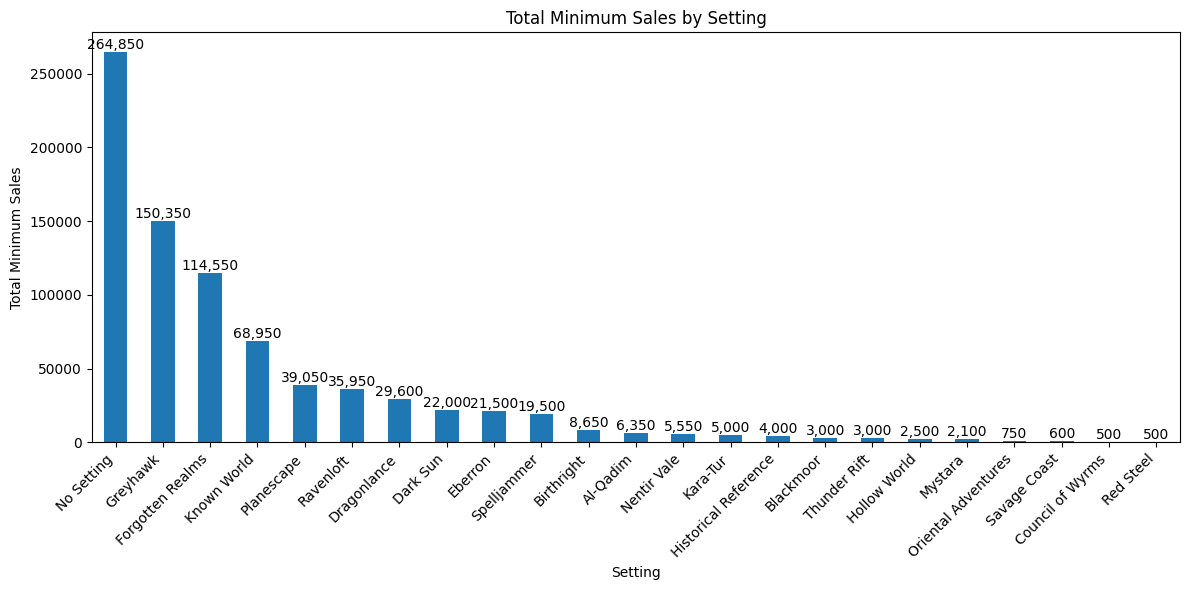

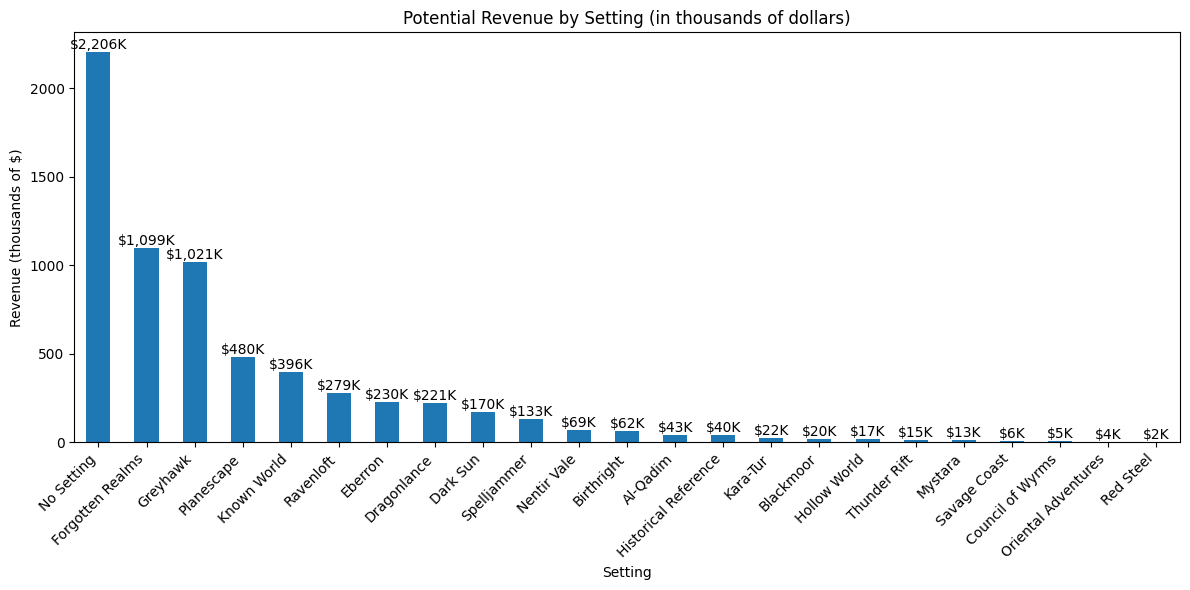

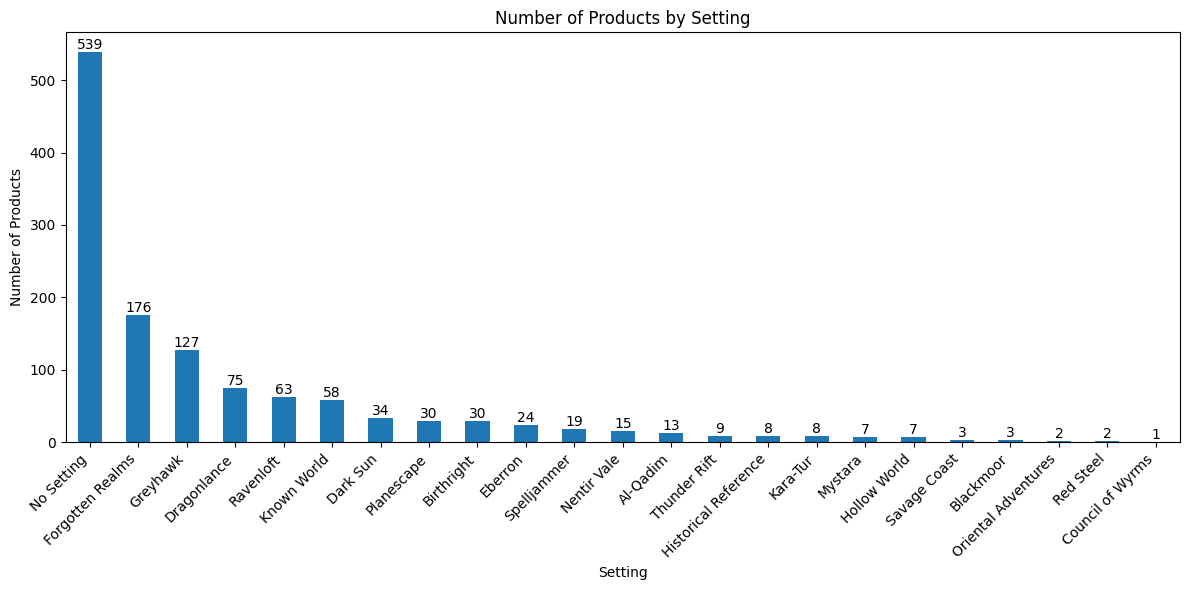


Top 5 Settings by Minimum Sales:
                  min_sales
setting                    
No Setting           264850
Greyhawk             150350
Forgotten Realms     114550
Known World           68950
Planescape            39050

Top 5 Settings by Potential Revenue (in thousands of dollars):
                    revenue
setting                    
No Setting        2206.2545
Forgotten Realms  1099.2550
Greyhawk          1021.0515
Planescape         479.5195
Known World        395.8490

Top 5 Settings by Number of Products:
                    0
setting              
No Setting        539
Forgotten Realms  176
Greyhawk          127
Dragonlance        75
Ravenloft          63


In [9]:
import matplotlib.pyplot as plt

# Calculate totals per setting
setting_sales = products_df.groupby('setting')['min_sales'].sum().sort_values(ascending=False)

# Calculate revenue in thousands of dollars
products_df['revenue'] = products_df['min_sales'] * products_df['price']
setting_revenue = (products_df.groupby('setting')['revenue'].sum() / 1000).sort_values(ascending=False)

# Count products per setting
setting_counts = products_df.groupby('setting').size().sort_values(ascending=False)

# Create separate plots
plt.figure(figsize=(12, 6))

# Plot 1: Min Sales
plt.subplot(1, 1, 1)
setting_sales.plot(kind='bar')
plt.title('Total Minimum Sales by Setting')
plt.xlabel('Setting')
plt.ylabel('Total Minimum Sales')
plt.xticks(rotation=45, ha='right')

# Add value labels
for i, v in enumerate(setting_sales):
    plt.text(i, v, f'{v:,.0f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Create new figure for second plot
plt.figure(figsize=(12, 6))

# Plot 2: Revenue
setting_revenue.plot(kind='bar')
plt.title('Potential Revenue by Setting (in thousands of dollars)')
plt.xlabel('Setting')
plt.ylabel('Revenue (thousands of $)')
plt.xticks(rotation=45, ha='right')

# Add value labels
for i, v in enumerate(setting_revenue):
    plt.text(i, v, f'${v:,.0f}K', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Create new figure for third plot
plt.figure(figsize=(12, 6))

# Plot 3: Product Counts
setting_counts.plot(kind='bar')
plt.title('Number of Products by Setting')
plt.xlabel('Setting')
plt.ylabel('Number of Products')
plt.xticks(rotation=45, ha='right')

# Add value labels
for i, v in enumerate(setting_counts):
    plt.text(i, v, f'{v:,.0f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Print the actual numbers
print("\nTop 5 Settings by Minimum Sales:")
print(setting_sales.head().to_frame())
print("\nTop 5 Settings by Potential Revenue (in thousands of dollars):")
print(setting_revenue.head().to_frame())
print("\nTop 5 Settings by Number of Products:")
print(setting_counts.head().to_frame())

# Do regressions to look for correlations with Metal types

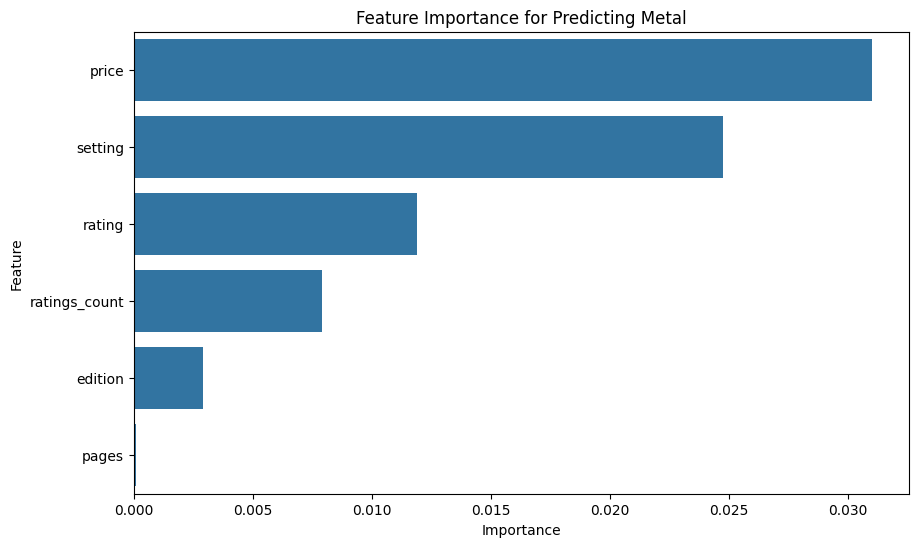

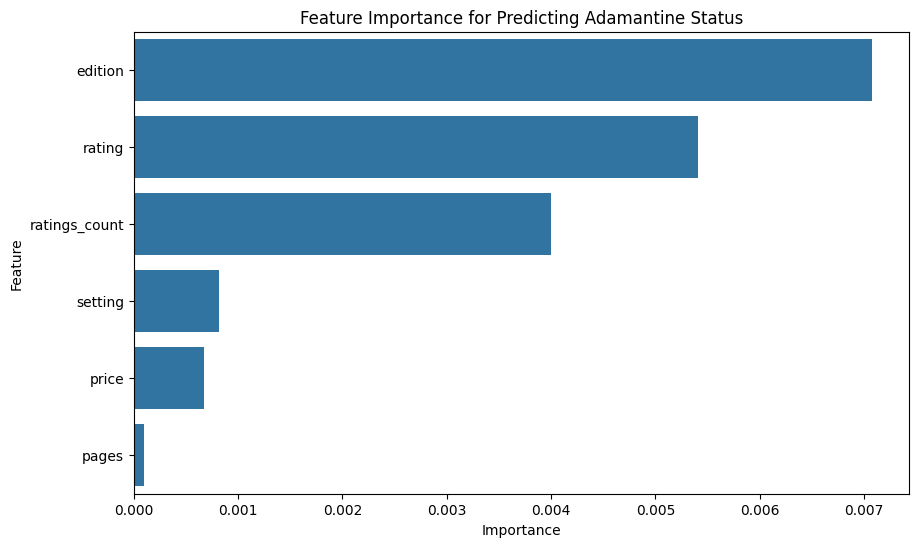


Feature Importance for Predicting Adamantine Status:
         Feature  Importance
4        edition    0.007077
0         rating    0.005404
3  ratings_count    0.004004
5        setting    0.000816
2          price    0.000671
1          pages    0.000099


In [18]:
# First regression (your existing code)
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Prepare features
numeric_features = ['rating', 'pages', 'price', 'ratings_count']
categorical_features = ['edition', 'metal', 'setting']

# Create a proper copy of the cleaned DataFrame
products_df_clean = products_df.dropna(subset=numeric_features + categorical_features).copy()

le = LabelEncoder()
# Now run the regression on cleaned data
X = products_df_clean[numeric_features].copy()
X['edition_encoded'] = le.fit_transform(products_df_clean['edition'])
X['setting_encoded'] = le.fit_transform(products_df_clean['setting'])
y = le.fit_transform(products_df_clean['metal'])

reg = LinearRegression()
reg.fit(X, y)

feature_importance = pd.DataFrame({
   'Feature': numeric_features + ['edition', 'setting'],
   'Importance': np.abs(reg.coef_)
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='Importance', y='Feature')
plt.title('Feature Importance for Predicting Metal')
plt.show()

# Second regression (for Adamantine prediction)
# Create binary target for Adamantine using .loc
products_df_clean.loc[:, 'is_adamantine'] = (products_df_clean['metal'] == 'Adamantine seller').astype(int)

# Use same features but predict is_adamantine
X_adamantine = X.copy()  # Use same features as before
y_adamantine = products_df_clean['is_adamantine']

reg_adamantine = LinearRegression()
reg_adamantine.fit(X_adamantine, y_adamantine)

feature_importance_adamantine = pd.DataFrame({
   'Feature': numeric_features + ['edition', 'setting'],
   'Importance': np.abs(reg_adamantine.coef_)
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance_adamantine, x='Importance', y='Feature')
plt.title('Feature Importance for Predicting Adamantine Status')
plt.show()

# Print the importance values
print("\nFeature Importance for Predicting Adamantine Status:")
print(feature_importance_adamantine)

# Automatically updating the setting where its obvious and saving back to disk

In [ ]:
import re

# Initialize setting column if it doesn't exist
if 'setting' not in products_df.columns:
    products_df['setting'] = None

FORGOTTEN_REALMS = 'Forgotten Realms'
FR_PRODUCT_STRINGS = ['Forgotten Realms', 'Serpent Kingdoms (3.5)', 'Unapproachable East (3.5)', 'Shining South (3.5)']

def check_setting_info(target_string, df):
    """
    Returns a dataframe containing rows where name contains target_string
    """
    target_string = re.escape(target_string)
    return df[df['name'].str.contains(target_string, case=False, na=False)].copy()

def update_setting(target_string, setting, df):
    """
    Updates the setting column for rows where name contains target_string
    and setting is currently NaN
    """
    target_string = re.escape(target_string)
    mask = (df['name'].str.contains(target_string, case=False, na=False)) & (df['setting'].isna())
    df.loc[mask, 'setting'] = setting
    return mask.sum()  # Return number of rows actually updated


def check_and_update_setting(df, target_strings, target_setting):
    """
    Updates settings for Forgotten Realms related products where setting is NaN
    Returns number of updated records for each target string
    """
    working_df = df.copy()
    updates = {}

    for target_string in target_strings:
        # Get matching records that have NaN settings
        results_df = check_setting_info(target_string, working_df)
        nan_results = results_df[results_df['setting'].isna()]
        results_count = len(nan_results)

        updates[target_string] = results_count
        print(f'Records to update for {target_string}: {results_count}')

        if results_count > 0:
            update_setting(target_string, target_setting, working_df)

    return updates, working_df

# Update Birthright
BIRTHRIGHT = 'Birthright'
BIRTHRIGHT_PRODUCT_STRINGS = ['Birthright', "Player's Secrets"]
update_results, products_df = check_and_update_setting(products_df, BIRTHRIGHT_PRODUCT_STRINGS, BIRTHRIGHT)

# Update DARK_SUN
DARK_SUN = 'Dark Sun'
DARK_SUN_PRODUCT_STRINGS = ['Dark Sun','Athas']
update_results, products_df = check_and_update_setting(products_df, DARK_SUN_PRODUCT_STRINGS, DARK_SUN)

# Update Dragonlance
DRAGONLANCE = 'Dragonlance'
DRAGONLANCE_PRODUCT_STRINGS = ['Dragonlance', 'SAGA', 'krynn']
update_results, products_df = check_and_update_setting(products_df, DRAGONLANCE_PRODUCT_STRINGS, DRAGONLANCE)

# Update Eberron
EBERRON = 'Eberron'
EBERRON_PRODUCT_STRINGS = ['Eberron']
update_results, products_df = check_and_update_setting(products_df, EBERRON_PRODUCT_STRINGS, EBERRON)

# Update FR
FORGOTTEN_REALMS = 'Forgotten Realms'
FR_PRODUCT_STRINGS = ['Forgotten Realms', 'Serpent Kingdoms (3.5)',
                      'Unapproachable East (3.5)', 'Shining South (3.5)',
                      'Undermountain', 'elminster', 'volo']
update_results, products_df = check_and_update_setting(products_df, FR_PRODUCT_STRINGS, FORGOTTEN_REALMS)

# Update Greyhawk
GREYHAWK = 'Greyhawk'
GREYHAWK_PRODUCT_STRINGS = ['Greyhawk']
update_results, products_df = check_and_update_setting(products_df, GREYHAWK_PRODUCT_STRINGS, GREYHAWK)

# Update Mystara
MYSTARA = 'Mystara'
MYSTARA_PRODUCT_STRINGS = ['Mystara']
update_results, products_df = check_and_update_setting(products_df, MYSTARA_PRODUCT_STRINGS, MYSTARA)

# Update None
NO_SETTING = 'None'
NO_SETTING_PRODUCT_STRINGS = ['Handbook', 'Manual', 'Arcana', 'Folio',
                              'draconomicon', 'character', 'spell compendium',
                              'option', 'complete', 'dungeon master',
                              'fantastic locations', 'starter', 'cyclopedia',
                              'dungeon #', 'dragon #', 'challenge']
update_results, products_df = check_and_update_setting(products_df, NO_SETTING_PRODUCT_STRINGS, NO_SETTING)

# Update Plansescape
PLANESCAPE = 'Planescape'
PLANESCAPE_PRODUCT_STRINGS = ['planescape', 'planes of']
update_results, products_df = check_and_update_setting(products_df, PLANESCAPE_PRODUCT_STRINGS, PLANESCAPE)

# Update Ravenloft
RAVENLOFT = 'Ravenloft'
RAVENLOFT_PRODUCT_STRINGS = ['ravenloft', 'van richten', 'children of']
update_results, products_df = check_and_update_setting(products_df, RAVENLOFT_PRODUCT_STRINGS, RAVENLOFT)

# Update Spelljammer
SAVAGE_COAST = 'Savage Coast'
SAVAGE_COAST_PRODUCT_STRINGS = ['Savage Coast']
update_results, products_df = check_and_update_setting(products_df, SAVAGE_COAST_PRODUCT_STRINGS, SAVAGE_COAST)

# Update Spelljammer
SPELLJAMMER = 'Spelljammer'
SPELLJAMMER_PRODUCT_STRINGS = ['Spelljammer', 'space']
update_results, products_df = check_and_update_setting(products_df, SPELLJAMMER_PRODUCT_STRINGS, SPELLJAMMER)

products_df.to_csv('/content/drive/My Drive/dmsguild_products_settings.csv', index=False)

Records to update for Birthright: 0
Records to update for Player's Secrets: 13
Records to update for Dark Sun: 0
Records to update for Athas: 0
Records to update for Dragonlance: 0
Records to update for SAGA: 0
Records to update for krynn: 0
Records to update for Eberron: 0
Records to update for Forgotten Realms: 0
Records to update for Serpent Kingdoms (3.5): 0
Records to update for Unapproachable East (3.5): 0
Records to update for Shining South (3.5): 0
Records to update for Undermountain: 0
Records to update for elminster: 0
Records to update for volo: 6
Records to update for Greyhawk: 0
Records to update for gaz: 0
Records to update for Mystara: 0
Records to update for Handbook: 0
Records to update for Manual: 0
Records to update for Arcana: 0
Records to update for Folio: 0
Records to update for draconomicon: 0
Records to update for character: 0
Records to update for spell compendium: 0
Records to update for option: 0
Records to update for complete: 0
Records to update for dungeon

In [ ]:
handbook_df = products_df[products_df['name'].str.contains('challenge', case=False, na=False)]
handbook_df

,name,metal,date_added,url,rating,edition,authors,artists,pages,price,ratings_count,setting
45,"Book of Challenges: Dungeon Rooms, Puzzles, an...",Adamantine seller,2015-09-22,https://www.dmsguild.com/product/3736/Book-of-...,4.5,3rd Edition (d20 System),"['Daniel Kaufman', 'Gwendolyn Kestrel', 'Mike ...","['Todd Lockwood', 'David Day', 'Wayne Reynolds']",128.0,12.99,64.0,NaN
737,OA6 Ronin Challenge (2e),Electrum seller,2016-12-20,https://www.dmsguild.com/product/200813/OA6-Ro...,5.0,2nd Edition,"['Curtis Smith', 'Rick Swan']","['James Holloway', 'Curtis Smith', 'Stephen Su...",96.0,4.99,3.0,NaN
822,HHQ3 Thief's Challenge (2e),Gold seller,2013-04-30,https://www.dmsguild.com/product/17309/HHQ3-Th...,4.5,2nd Edition,['Troy Christensen'],"['Jeff Easley', 'Gary Williams']",32.0,4.99,12.0,NaN
866,HHQ1 Fighter's Challenge (2e),Gold seller,2013-03-19,https://www.dmsguild.com/product/17306/HHQ1-Fi...,4.5,2nd Edition,['John Terra'],"['John Lakey', 'Laura Lakey', 'Karl Waller', '...",32.0,4.99,17.0,NaN
867,HHQ2 Wizard's Challenge (2e),Gold seller,2013-04-09,https://www.dmsguild.com/product/17307/HHQ2-Wi...,4.3,2nd Edition,['Tim Beach'],"['Eric Olson', 'Karl Waller']",32.0,4.99,9.0,NaN
931,HHQ4 Cleric's Challenge (2e),Gold seller,2013-05-14,https://www.dmsguild.com/product/17466/HHQ4-Cl...,4.4,2nd Edition,['L. Richard Baker III'],"['Larry Elmore', 'Ken Frank', 'Charles Frank']",32.0,4.99,12.0,NaN
1077,HHQ5 Fighter's Challenge II (2e),Electrum seller,2013-07-17,https://www.dmsguild.com/product/17313/HHQ5-Fi...,3.0,2nd Edition,['Drew Bittner'],"['Valerie Valusek', 'Eric Olson']",32.0,4.99,5.0,NaN
1078,HHQ6 Wizard's Challenge II (2e),Electrum seller,2013-08-20,https://www.dmsguild.com/product/17316/HHQ6-Wi...,4.7,2nd Edition,['Kevin Melka'],"['Clyde Caldwell', 'Terry Dykstra']",32.0,4.99,7.0,NaN
1079,HHQ7 Thief's Challenge II: Beacon Point (2e),Electrum seller,2013-08-27,https://www.dmsguild.com/product/17317/HHQ7-Th...,4.0,2nd Edition,['Terry Amthor'],"['Jeff Easley', 'David Day']",32.0,4.99,6.0,NaN
1142,HHQ8 Cleric's Challenge II (2e),Electrum seller,2013-09-03,https://www.dmsguild.com/product/17326/HHQ8-Cl...,4.6,2nd Edition,['Paul F. Culotta'],"['Doug Chaffee', 'Dennis Cramer']",32.0,4.99,8.0,NaN
